# Simple demonstration of discrete Markov processes

Toni Giorgino (IBF-CNR)


## Discrete Markov processes

A (discrete-time) Markov chain (DTMC) is a sequence of random variables, known as a stochastic process, in which the value of the next variable depends only on the value of the current variable, and not any variables in the past.

At any given time the system is in one (and only one) of several *states*. We'll deal
with *homogeneous* MC, so transition between states are governed by constant probabilities which only depend on the current state (memorylessness, or Markovian property).

We copy the matrices encoding two examples seen during the lecture:

In [1]:
# The weather example
weatherP <- matrix( c(0.6,  0.3,  0.1,
                      0.2,  0.3,  0.5,
                      0.4,  0.1,  0.5  ), 
                    nrow = 3, byrow = T)

# The "colored blocks" trajectory example
colortrajP <- matrix( c(3/5,  0,  2/5,
                        1/4, 3/4, 0,
                        1/4, 2/4, 1/4  ), 
                      nrow = 3, byrow = T)

Note how the rows sum to unity (conservation of probability): the state must
go somewhere.

For the sake of illustration, we work with the first ("weather") example.

![weather](img/weather.png)

## Sampling the chain

The simplest thing we can do is *sample* the chain, i.e.
follow the probabilities to obtain one realization (here for 30 steps).

In [2]:
# Sample a Markov chain 
sample.markov <- function(P, n, s0=1) {
        N <- nrow(P)
        s <- s0
        ret <- s
        for (i in 2:n) {
                p <- P[s, ] 
                nx <- sample(1:N, size=1, prob=p)
                ret <- c(ret, nx)
                s <- nx
        }
        return(ret)
}

In [3]:
P <- weatherP
# Extract 30 time steps
sample.markov(P, 30)

[1] 1 1 2 3 1 1 1 1 1 1 1 1 2 3 3 1 1 2 2 3 3 1 2 3 3 1 3 3 3 3


## Stationary state


Question: if we play the game a very long time, what fraction of time would we spend in each state?

* That is the asymptotic (equilibrium) distribution.
* I.e., the probability of finding the system in a given state.


In [4]:
# Check the stationary state by extracting 1000 samples
N <- 1000
sN <- sample.markov(P, N)
print(table(sN))

sN
  1   2   3 
436 257 307 



This is just an approximate, compute-intensive 
realization. The power of the Markov formalism lies
in the fact that such quantities can be computed from
the matrix *P* right away. For example,
the stationary distribution is computed
from the first eigenvector (see function `sstate`).

In [5]:
# Remove imaginary part if small
dropSmallImaginary <- function(x) {
        if (all(Im(z <- zapsmall(x))==0)) as.numeric(z) else x
}

# Extract stationary state as eigenvector of eigenvalue=1
sstate <- function(M) {
        ev<-eigen(t(M))
        if(dropSmallImaginary(ev$values[1]) != 1) 
                stop("First EV not 1")
        ss <- ev$vectors[,1] / sum(ev$vectors[,1])
        dropSmallImaginary(ss)
}


In [6]:
ss <- sstate(P)
print(ss)

[1] 0.4411765 0.2352941 0.3235294


The exact estimate approximates well the samples.
We represent both graphically.

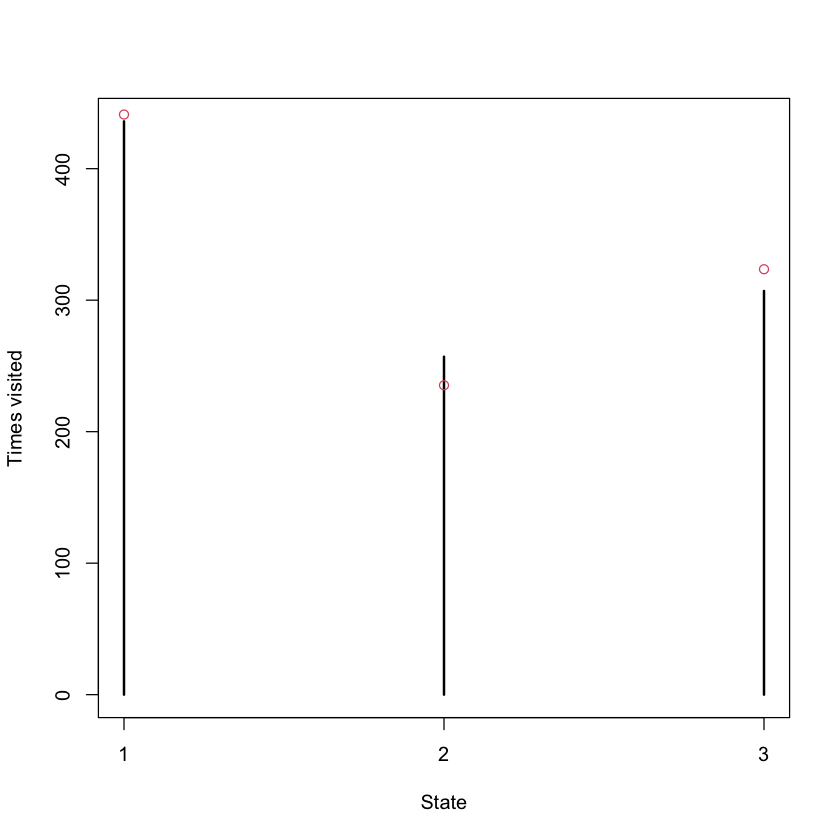

In [7]:

plot(table(sN), xlab="State", ylab="Times visited")
# Compare with the theory
points(1:3, N*ss, col=2)


Stationary probabilities can be converted readily
into free energy differences (ΔG), up to an
irrelevant additive constant. Assuming *T* = 298 K,

In [8]:

kB <- 0.001985875    # kcal/mol/K
dG <- -kB * 298 * log(ss)
dG

[1] 0.4842684 0.8562733 0.6678153


in units of kcal/mol. It is convenient to set the lowest-energy 
state (the most stable) to 0 kcal/mol.

In [9]:
dG-min(dG)

[1] 0.0000000 0.3720049 0.1835469


## Recover the transition count matrix from a sequence

Here we do the reverse than before: instead of
using the transition probability matrix to sample a sequence,
we now use a sequence to recover the transition count matrix
(later I'll normalize it to get a transition *probability* matrix).

Technically, I use a trick: I prepare a data frame with one 
column (I) holding the sampled values, and another
(J) holding the same values lagged by  1 time
step. So, I can just count the I,J pairs (with the
`table` function).


In [10]:

library(zoo)
dij <- data.frame(i = sN,
                  j = lag(zoo(sN), 1, na.pad=T))
dij <- na.omit(dij)  # The very last transition is not valid
T <- table(dij)
addmargins(T)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




,1,2,3,Sum
1,269,131,36,436
2,47,83,126,256
3,119,43,145,307
Sum,435,257,307,999



Now normalize by rows. Note how close it is to the
original matrix.

In [11]:

estP <- T/rowSums(T)
estP

   j
i            1          2          3
  1 0.61697248 0.30045872 0.08256881
  2 0.18359375 0.32421875 0.49218750
  3 0.38762215 0.14006515 0.47231270



## Markovianity

The sequence of states that we sampled is markovian
**by construction**. However, in general (for real-world timeseries)
this is not a given.

To test markovianity, I will counts the transitions I->J but
this time considering separately whether they were preceded by 
K = 1, 2 or 3. In other words, I will count  occurrences of these
sequences: 1-I-J,  2-I-J, 3-I-J.

Remember that the Markov property reads:

$$ p(s_t | s_{t-1}, s_{t-2}, \dots ) = p(s_t | s_{t-1} ) $$
in our case, J is the destination state $s_t$, I is $s_{t-1}$,
and the preceeding state K is $s_{t-2}$.

As above, I use lags and tabulation.

In [12]:

dkij <- data.frame(k = sN,
                   i = lag(zoo(sN), 1, na.pad=T),
                   j = lag(zoo(sN), 2, na.pad=T))
dkij <- na.omit(dkij)  # The very last transition is not valid
print(head(dkij))

Warning message in if (na.pad) merge(zoo(, time(x)), xx, all = c(TRUE, FALSE)) else xx:
“la condizione la lunghezza > 1 e solo il promo elemento verrà utilizzato”
Warning message in if (na.pad) merge(zoo(, time(x)), xx, all = c(TRUE, FALSE)) else xx:
“la condizione la lunghezza > 1 e solo il promo elemento verrà utilizzato”


  k i j
1 1 2 3
2 2 3 3
3 3 3 1
4 3 1 3
5 1 3 1
6 3 1 1


Probabilities should be independent from K. They will eventually be, 
if we sample long enough.

In [13]:
T3<-table(dkij)
# Sequences 1-I-J, i.e. K=1
print(T3[1,,]/rowSums(T3[1,,]))
# Sequences 2-I-J, i.e. K=2
print(T3[2,,]/rowSums(T3[2,,]))
# Sequences 3-I-J, i.e. K=3
print(T3[3,,]/rowSums(T3[3,,]))

   j
i            1          2          3
  1 0.63568773 0.28252788 0.08178439
  2 0.16793893 0.32824427 0.50381679
  3 0.41666667 0.16666667 0.41666667
   j
i           1         2         3
  1 0.5744681 0.4042553 0.0212766
  2 0.1951220 0.3048780 0.5000000
  3 0.3650794 0.1587302 0.4761905
   j
i           1         2         3
  1 0.5966387 0.2941176 0.1092437
  2 0.2093023 0.3488372 0.4418605
  3 0.4000000 0.1172414 0.4827586


## The probabilistic point of view

Markov chains can also be followed stochastically,
propagating the probability density. Again you will realize
that (under suitable conditions usually met), regardless 
of the initial state, the final probability distribution
converges towards the equilibrium one.

Of note, the "memory" of the initial state is lost after
a transient (related to the second eigenvalue).

In [15]:

# Compute time-dependent probabilities of a Markov chain. Same
# as taking the n-th power of the matrix P
probs.markov <- function(P, n, s0 = c(1,rep(0,nrow(P)-1))) {
        N <- nrow(P)
        s <- s0
        ret <- s
        for (i in 2:n) {
                s <- s %*% P
                ret <- rbind(ret, s)
        }
        return(ret)
}

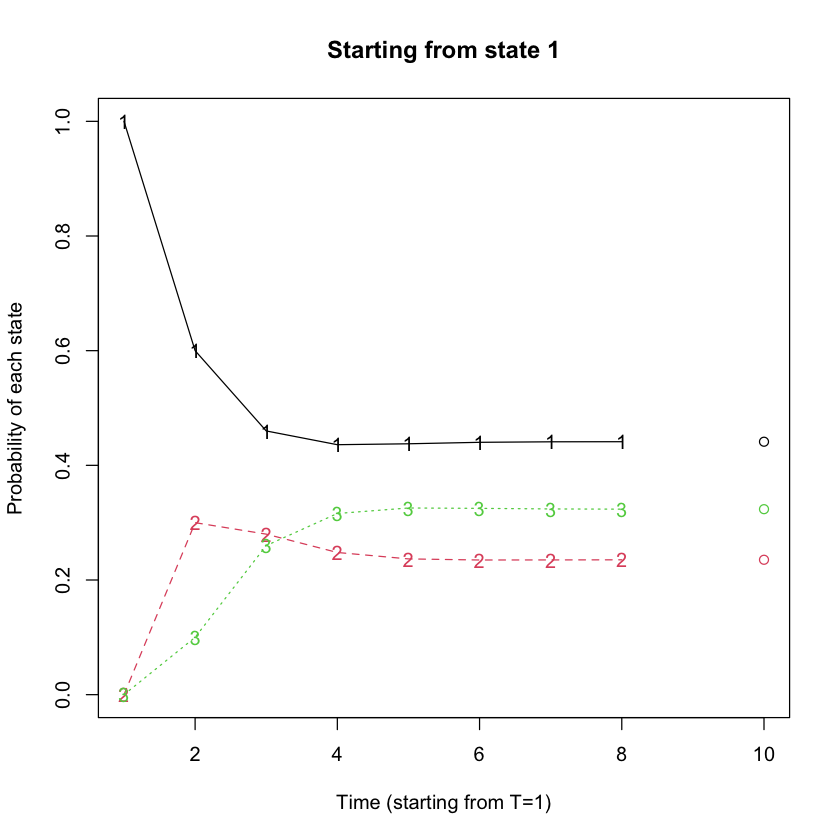

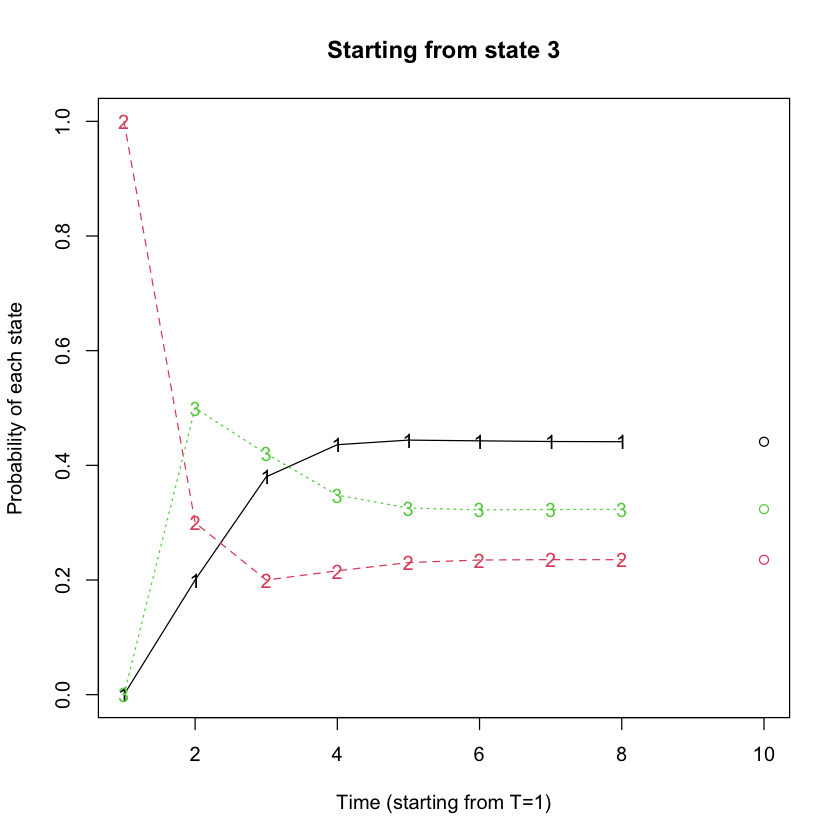

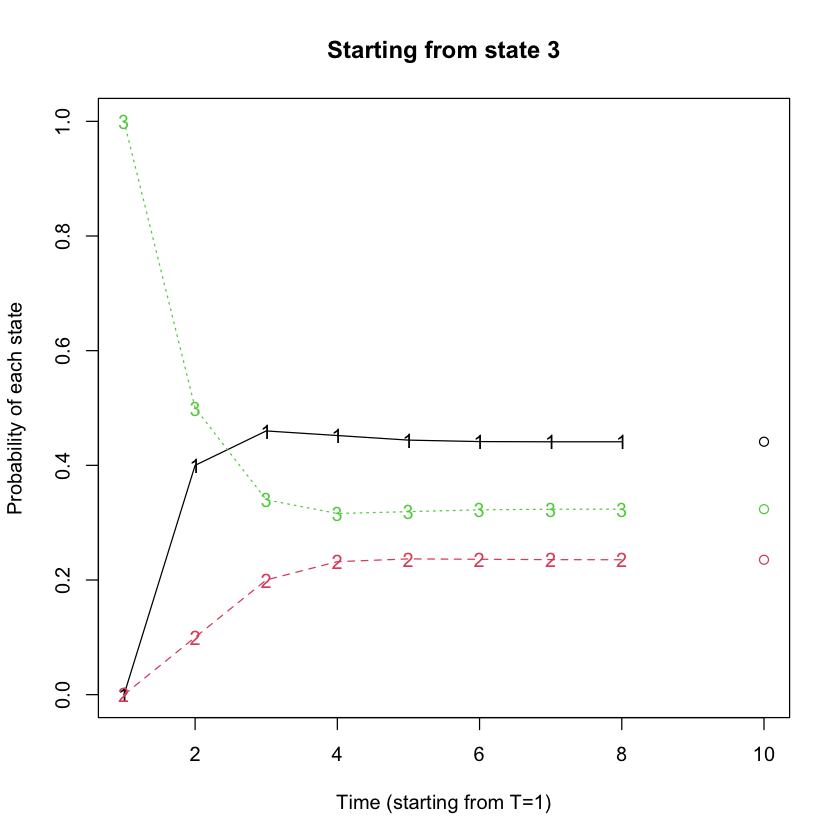

In [16]:
pT <- probs.markov(P, 8)
matplot(pT, type="o", 
        xlim = c(1,10),
        xlab="Time (starting from T=1)", 
        ylab="Probability of each state",
        main="Starting from state 1")
points(rep(10,3),ss,col=1:3)
pT <- probs.markov(P, 8, c(0,1,0))
matplot(pT, type="o", 
        xlim = c(1,10),
        xlab="Time (starting from T=1)", 
        ylab="Probability of each state",
        main="Starting from state 3")
points(rep(10,3),ss,col=1:3)
pT <- probs.markov(P, 8, c(0,0,1))
matplot(pT, type="o", 
        xlim = c(1,10),
        xlab="Time (starting from T=1)", 
        ylab="Probability of each state",
        main="Starting from state 3")
points(rep(10,3),ss,col=1:3)